In [1]:
import numpy as np
from model import *
import tensorflow as tf
import setGPU
#strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

imgs = np.load('../dataset/cv/train/x/generated_text_2.npz')['arr_0']
labels = np.load('../dataset/cv/train/y/generated_labels_2.npy')

setGPU: Setting GPU to: 0


In [2]:
characters = set(char for label in labels for char in label)

In [3]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
                  vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None )

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                  vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True )

In [4]:
imgs = np.transpose(imgs, (0, 2, 1, 3))
'''
max_len = max([len(label) for label in labels])
encoded_labels = []
for label in labels:
    if label:
        tmp = np.array([char_to_num(char) for char in label])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
    else:
        tmp = np.array([char_to_num('#')])
        encoded_labels.append(np.pad(tmp, (0, max_len-tmp.shape[0]), constant_values=0))
'''

encoded_labels = np.load('../dataset/cv/train/y/encoded_labels_2.npy')

In [5]:
#Si inserisce alla fine di ogni array label la lunghezza reale della parola
t_dist_dim = int(128)          # Questo valore indica quanti step temporali ci sono: nelle ultime feature map ci sono 128/4
                                 # step temporali perché 128 è la larghezza massima tra le immagini in ingresso e 4 è il fattore
                                 # di riduzione dovuto ai MaxPooling (ci sono 2 livelli di MaxPooling che dimezzano le dimensioni)
enc2 = []
for i in range(encoded_labels.shape[0]):
    if len(labels[i]) == 0:
        enc2.append(np.append(encoded_labels[i], [1, t_dist_dim]))
    else:
        enc2.append(np.append(encoded_labels[i], [len(labels[i]), t_dist_dim]))
enc2 = np.array(enc2)

In [6]:
#with strategy.scope():
net = build_and_compile_model_v10_2(input_shape=(128, 32, 1), len_characters=len(characters), opt="Adam")

In [7]:
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 32, 8)   80          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 32, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 32, 16)  1168        activation[0][0]                 
_______________________________________________________________________________________

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Early_Stopping_Patience = 10 
Min_Delta = 0.0001
# Model Check Point
Check_Point = ModelCheckpoint( 'weights/CRNN_v10_2.h5',   # Filepath
                               monitor='val_loss',
                               save_best_only=True,
                               verbose=1,
                               mode='auto',
                               save_weights_only=False,
                               save_freq='epoch' )
# Add early stopping
Early_Stopping = EarlyStopping( monitor='val_loss',
                                min_delta=Min_Delta,
                                patience=Early_Stopping_Patience,
                                verbose=1,
                                mode='auto',
                                baseline=None,
                                restore_best_weights=True )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=10, min_lr=0.0002)

In [9]:
batch_size = 64
x_train = imgs
y_train = enc2

In [10]:
history = net.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[Check_Point, reduce_lr], batch_size=batch_size, shuffle=True)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 37.7502
Epoch 00001: val_loss improved from inf to 27.24130, saving model to weights/CRNN_v10_2.h5
125/125 [==============================] - 9s 76ms/step - loss: 37.7502 - val_loss: 27.2413
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 26.4739
Epoch 00002: val_loss improved from 27.24130 to 27.12935, saving model to weights/CRNN_v10_2.h5
125/125 [==============================] - 8s 68ms/step - loss: 26.4739 - val_loss: 27.1293
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 26.3062
Epoch 00003: val_loss improved from 27.12935 to 26.59156, saving model to weights/CRNN_v10_2.h5
125/125 [==============================] - 8s 68ms/step - loss: 26.3062 - val_loss: 26.5916
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 26.2145
Epoch 00004: val_loss improved from 26.59156 to 26.41762, saving model to weights/CRNN_v10_2.h5
125/125 [====================

Epoch 34/100
125/125 [==============================] - ETA: 0s - loss: 0.3704
Epoch 00034: val_loss did not improve from 1.03900
125/125 [==============================] - 8s 67ms/step - loss: 0.3704 - val_loss: 7.3490
Epoch 35/100
125/125 [==============================] - ETA: 0s - loss: 0.4229
Epoch 00035: val_loss did not improve from 1.03900
125/125 [==============================] - 8s 67ms/step - loss: 0.4229 - val_loss: 1.2698
Epoch 36/100
125/125 [==============================] - ETA: 0s - loss: 0.3658
Epoch 00036: val_loss did not improve from 1.03900
125/125 [==============================] - 8s 67ms/step - loss: 0.3658 - val_loss: 1.7658
Epoch 37/100
125/125 [==============================] - ETA: 0s - loss: 0.2876
Epoch 00037: val_loss did not improve from 1.03900
125/125 [==============================] - 8s 67ms/step - loss: 0.2876 - val_loss: 1.7918
Epoch 38/100
125/125 [==============================] - ETA: 0s - loss: 0.2849
Epoch 00038: val_loss did not improve fro

KeyboardInterrupt: 

In [ ]:
np.save('history/my_history_v5.npy',history.history)

In [23]:
import numpy as np
his = np.load('my_history_v5.npy', allow_pickle=True)

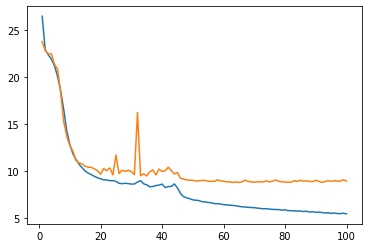

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), history.history['loss'])
plt.plot(range(1, 101), history.history['val_loss'])

In [14]:
import imageio

im = imageio.imread('../dataset/cv/train/mario.png')

In [15]:
import cv2
from skimage import color

im = cv2.resize(im, (128, 128))
im = color.rgb2gray(im)

<ipython-input-15-d15eb699efec>:5: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  im = color.rgb2gray(im)


In [16]:
im = np.expand_dims(im, axis=-1)

In [17]:
def decode_ctc(args):
    """returns a list of decoded ctc losses"""

    y_pred, input_length = args

    ctc_decoded = tf.keras.backend.ctc_decode(
        y_pred, input_length, greedy=True)

    return ctc_decoded

In [21]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [22]:
pred_labels

array([[14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [23]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[

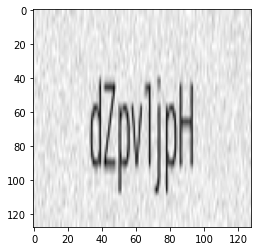

In [33]:
import matplotlib.pyplot as plt
plt.imshow(im, cmap='gray')
plt.show()

In [15]:
net.load_weights('weights/CRNN_v10_5.h5')

Missing modules for handwritten text generation.


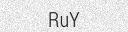

In [1]:
from trdg.generators import GeneratorFromRandom  
base_generator = GeneratorFromRandom(use_symbols=False, use_letters=True, length=1, width=128, size=32)
img, lbl = next(base_generator)
display(img)

In [29]:
import cv2
from skimage import color
im = cv2.resize(np.array(img), (128, 128))
im = color.rgb2gray(im)
im = np.expand_dims(im, axis=-1)

In [2]:
import cv2
from skimage import color
import numpy as np
imgs = []
lbls = []
for i in range(10000):
    print(i)
    img, lbl = next(base_generator)
    im = color.rgb2gray(np.array(img))
    im = np.expand_dims(im, axis=-1)
    imgs.append(im)
    lbls.append(lbl)
np.savez_compressed('../dataset/cv/train/x/generated_text_2',np.array(imgs))
np.save('../dataset/cv/train/y/generated_labels_2', np.array(lbls))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084


3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732


5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411


6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072


8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746


In [5]:
lbls[0]

'2z3D'

In [30]:
pred_tensor, _ = decode_ctc([net.predict(np.expand_dims(im, axis=0)), np.array([t_dist_dim])])
pred_labels = tf.keras.backend.get_value(pred_tensor[0])

In [31]:
pred_labels

array([[14, 25, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]])

In [32]:
num_to_char(pred_labels)

<tf.Tensor: shape=(1, 128), dtype=string, numpy=
array([[b'E', b'P', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]',
        b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]', b'[UNK]

In [26]:
labels[50]

'ht'